In [21]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib


In [22]:

# ============================================================
# 設定（ここだけ変更）
# ============================================================
TRAIN_CSV = "data_train_notSmooth.csv"
TEST_CSV  = "data_test_notSmooth.csv"

TIME_COL  = "t"        # 無ければサンプル番号を使う
LABEL_COL = "label"    # 無ければ色分けなし
SENSOR_COLS = ["s1", "s2"]     # 例: ["s1","s2","s3"] / Noneなら自動推定（sで始まる列優先）
N_PLOTS = 3            # 上から何本のセンサを描くか（データごとに同じ指定）

label_name = {
    0: "正常",
    1: "周波数変化",
    2: "シフト",
    3: "位相",
    4: "スパイク",
}

# ============================================================
# 1) train/test を読み込み
# ============================================================
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)




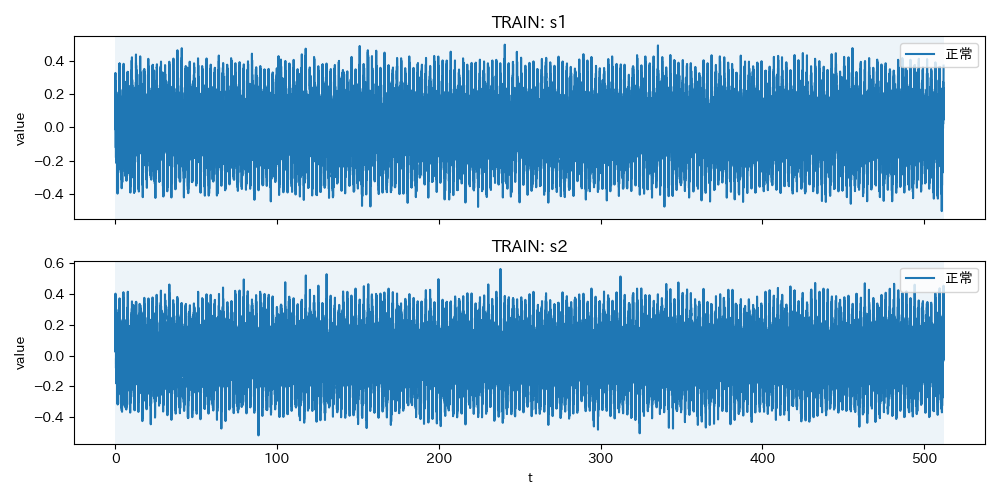

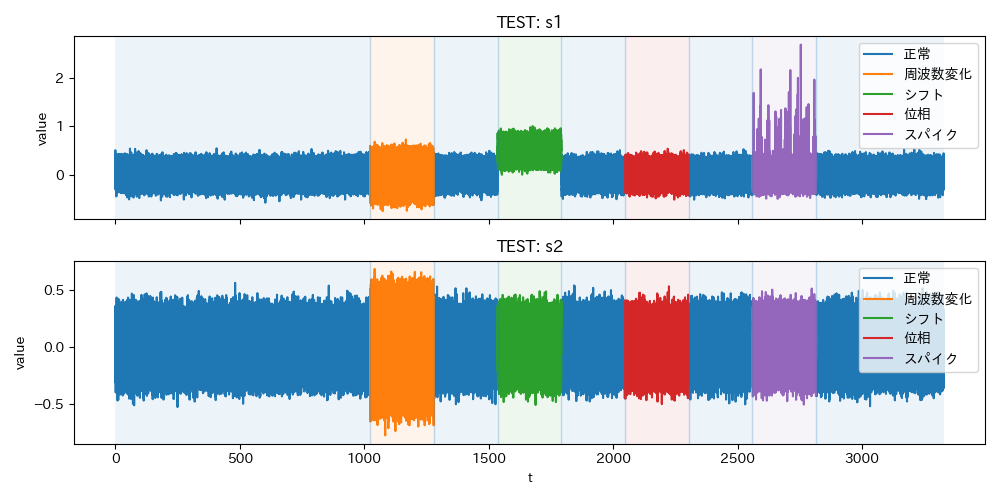

In [23]:
# ============================================================
# 2) TRAIN: x と label（あれば）を準備
# ============================================================
x_tr = df_train[TIME_COL].to_numpy(dtype=float) if TIME_COL in df_train.columns else np.arange(len(df_train), dtype=float)
xlab_tr = TIME_COL if TIME_COL in df_train.columns else "sample_index"

has_lab_tr = (LABEL_COL in df_train.columns)
if has_lab_tr:
    lab_tr = df_train[LABEL_COL].to_numpy()
    lab_tr = lab_tr.astype(int) if np.issubdtype(lab_tr.dtype, np.number) else pd.Series(lab_tr).astype("category").cat.codes.to_numpy()
    chg_tr = np.where(lab_tr[1:] != lab_tr[:-1])[0] + 1
    edges_tr = np.r_[0, chg_tr, len(lab_tr)]

# ============================================================
# 3) TEST: x と label（あれば）を準備
# ============================================================
x_te = df_test[TIME_COL].to_numpy(dtype=float) if TIME_COL in df_test.columns else np.arange(len(df_test), dtype=float)
xlab_te = TIME_COL if TIME_COL in df_test.columns else "sample_index"

has_lab_te = (LABEL_COL in df_test.columns)
if has_lab_te:
    lab_te = df_test[LABEL_COL].to_numpy()
    lab_te = lab_te.astype(int) if np.issubdtype(lab_te.dtype, np.number) else pd.Series(lab_te).astype("category").cat.codes.to_numpy()
    chg_te = np.where(lab_te[1:] != lab_te[:-1])[0] + 1
    edges_te = np.r_[0, chg_te, len(lab_te)]

# 背景色（matplotlibデフォルト色）
def _lab_color(labv):
    return f"C{int(labv) % 10}"

# ============================================================
# 4) プロット（TRAIN） 背景色つき（ラベル列がある時だけ）
# ============================================================
fig, axes = plt.subplots(len(SENSOR_COLS), 1, figsize=(10, 2.5 * len(SENSOR_COLS)), sharex=True)
if len(SENSOR_COLS) == 1:
    axes = [axes]

for ax, col in zip(axes, SENSOR_COLS):
    y = df_train[col].to_numpy(dtype=float)

    if has_lab_tr:
        # 背景（ラベル区間ごと）
        for a, b in zip(edges_tr[:-1], edges_tr[1:]):
            labv = int(lab_tr[a])
            x0 = float(x_tr[a])
            x1 = float(x_tr[b]) if b < len(x_tr) else float(x_tr[-1])
            ax.axvspan(x0, x1, color=_lab_color(labv), alpha=0.08, linewidth=0)

        # 線（ラベルごと）
        for labv in sorted(np.unique(lab_tr)):
            m = (lab_tr == labv)
            ax.plot(x_tr[m], y[m], label=label_name.get(int(labv), str(int(labv))))

        # 区間境界線
        for idx in chg_tr:
            ax.axvline(float(x_tr[idx]), linewidth=1.0, alpha=0.25)

        ax.legend(loc="upper right", frameon=True)
    else:
        ax.plot(x_tr, y, label=col)
        ax.legend(loc="upper right", frameon=True)

    ax.set_title(f"TRAIN: {col}")
    ax.set_ylabel("value")

axes[-1].set_xlabel(xlab_tr)
fig.tight_layout()
plt.show()

# ============================================================
# 5) プロット（TEST） 背景色つき（ラベル列がある時だけ）
# ============================================================
fig, axes = plt.subplots(len(SENSOR_COLS), 1, figsize=(10, 2.5 * len(SENSOR_COLS)), sharex=True)
if len(SENSOR_COLS) == 1:
    axes = [axes]

for ax, col in zip(axes, SENSOR_COLS):
    y = df_test[col].to_numpy(dtype=float)

    if has_lab_te:
        # 背景（ラベル区間ごと）
        for a, b in zip(edges_te[:-1], edges_te[1:]):
            labv = int(lab_te[a])
            x0 = float(x_te[a])
            x1 = float(x_te[b]) if b < len(x_te) else float(x_te[-1])
            ax.axvspan(x0, x1, color=_lab_color(labv), alpha=0.08, linewidth=0)

        # 線（ラベルごと）
        for labv in sorted(np.unique(lab_te)):
            m = (lab_te == labv)
            ax.plot(x_te[m], y[m], label=label_name.get(int(labv), str(int(labv))))

        # 区間境界線
        for idx in chg_te:
            ax.axvline(float(x_te[idx]), linewidth=1.0, alpha=0.25)

        ax.legend(loc="upper right", frameon=True)
    else:
        ax.plot(x_te, y, label=col)
        ax.legend(loc="upper right", frameon=True)

    ax.set_title(f"TEST: {col}")
    ax.set_ylabel("value")

axes[-1].set_xlabel(xlab_te)
fig.tight_layout()
plt.show()


In [24]:
WIN  = 128*3
STEP = 128*3

FFT_K = 40
USE_LOG_AMP = False

WINDOW_LABEL_RULE = "majority"   # "majority" / "last" / "none"

# ============================================================
# 2) 共通：窓→FFT特徴量（窓ラベルもここで作る）
# ============================================================
def window_fft_features(
    df: pd.DataFrame,
    sensor_cols,
    win: int,
    step: int,
    fft_k: int,
    use_log_amp: bool,
    time_col: str = "t",
    label_col: str = "label",
    window_label_rule: str = "majority",
):
    n = len(df)
    starts = np.arange(0, n - win + 1, step, dtype=int)

    X_rows = []
    y_win = []
    t0_win = []

    has_time = (time_col in df.columns)
    has_lab  = (label_col is not None) and (label_col in df.columns) and (window_label_rule != "none")

    eps = 1e-12

    # 列名（固定）
    feat_cols = []
    for c in sensor_cols:
        for k in range(1, fft_k + 1):
            feat_cols.append(f"{c}_fft_amp{k}")

    for s in starts:
        e = s + win

        feats_all = []
        for c in sensor_cols:
            x = df[c].to_numpy(dtype=float)[s:e]
            x0 = x - x.mean()

            spec = np.fft.rfft(x0)
            amp = np.abs(spec)

            kmax = min(fft_k, len(amp) - 1)
            a = amp[1:1 + kmax]  # DC除外

            if use_log_amp:
                a = np.log(a + eps)

            if kmax < fft_k:
                a = np.pad(a, (0, fft_k - kmax), mode="constant", constant_values=0.0)

            feats_all.append(a)

        X_rows.append(np.concatenate(feats_all, axis=0))

        if has_lab:
            lab = df[label_col].to_numpy(dtype=int)[s:e]
            if window_label_rule == "last":
                y_win.append(int(lab[-1]))
            else:  # majority
                vals, cnts = np.unique(lab, return_counts=True)
                y_win.append(int(vals[np.argmax(cnts)]))

        if has_time:
            t0_win.append(float(df[time_col].to_numpy()[s]))
        else:
            t0_win.append(int(s))

    X = np.vstack(X_rows).astype(np.float32)
    X_df = pd.DataFrame(X, columns=feat_cols)

    meta = pd.DataFrame({
        "win_start": starts,
        "t0": np.array(t0_win),
    })

    y = np.array(y_win, dtype=int) if has_lab else None
    return X_df, y, meta

# ============================================================
# 3) train/test を同じ設定で変換
# ============================================================
X_train_df, y_train_win, meta_train = window_fft_features(
    df_train, SENSOR_COLS, WIN, STEP, FFT_K, USE_LOG_AMP,
    time_col=TIME_COL, label_col=LABEL_COL, window_label_rule=WINDOW_LABEL_RULE
)

X_test_df, y_test_win, meta_test = window_fft_features(
    df_test, SENSOR_COLS, WIN, STEP, FFT_K, USE_LOG_AMP,
    time_col=TIME_COL, label_col=LABEL_COL, window_label_rule=WINDOW_LABEL_RULE
)

print("X_train_df:", X_train_df.shape, " y_train_win:", None if y_train_win is None else y_train_win.shape)
print("X_test_df :", X_test_df.shape,  " y_test_win :", None if y_test_win  is None else y_test_win.shape)
print("meta_train:", meta_train.shape, "meta_test:", meta_test.shape)

X_train_df: (133, 80)  y_train_win: (133,)
X_test_df : (866, 80)  y_test_win : (866,)
meta_train: (133, 2) meta_test: (866, 2)


In [25]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDriftOnline

# ============================================================
# 4) Online MMD 用の入力（FFT特徴量をそのまま使う）
#   - X_train_df / X_test_df は「FFT特徴量の表」
#   - 生センサ名 ["s1","s2"] はもう列に存在しない（例: "s1_fft_amp1" など）
#   - 参照は「範囲（区間）」で切り出す（ランダム抽出しない）
# ============================================================

# --- 設定（ここだけ変えればOK） ---
REF_START = 0
REF_LEN   = 133      # 大きすぎると重くなるので小さめ推奨（例 100〜2000）
window_size  = 10
ert          = 50.0
n_bootstraps = 1000      # まず軽め。必要なら増やす
backend      = "tensorflow"

# ============================================================
# 4) Online MMD 用の入力（FFT特徴量をそのまま使う）
# ============================================================
FEATURE_COLS = list(X_train_df.columns)

X_ref_all = X_train_df[FEATURE_COLS].to_numpy(np.float32)
X_test    = X_test_df[FEATURE_COLS].to_numpy(np.float32)

ref_end = min(len(X_ref_all), REF_START + REF_LEN)
if ref_end - REF_START <= 1:
    raise ValueError("REF_LEN が小さすぎます（参照がほぼ空です）。")

X_ref = X_ref_all[REF_START:ref_end]

# --- 標準化（参照でfit→テストへ適用） ---
scaler = StandardScaler()
X_ref_std  = scaler.fit_transform(X_ref).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

# ============================================================
# 5) Online MMD（初期化）
# ============================================================
cd = MMDDriftOnline(
    x_ref=X_ref_std,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)



Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ============================================================
# 設定（ここだけ変更）
# ============================================================
LABEL_COL = "label"   # 無ければ None（例: LABEL_COL = None）

label_name = {
    0: "正常",
    1: "周波数変化",
    2: "シフト",
    3: "位相",
    4: "スパイク",
}

# 背景色（label_name に合わせて追加）
label_color = {
    0: "C0",
    1: "C1",
    2: "C2",
    3: "C3",
    4: "C4",
}


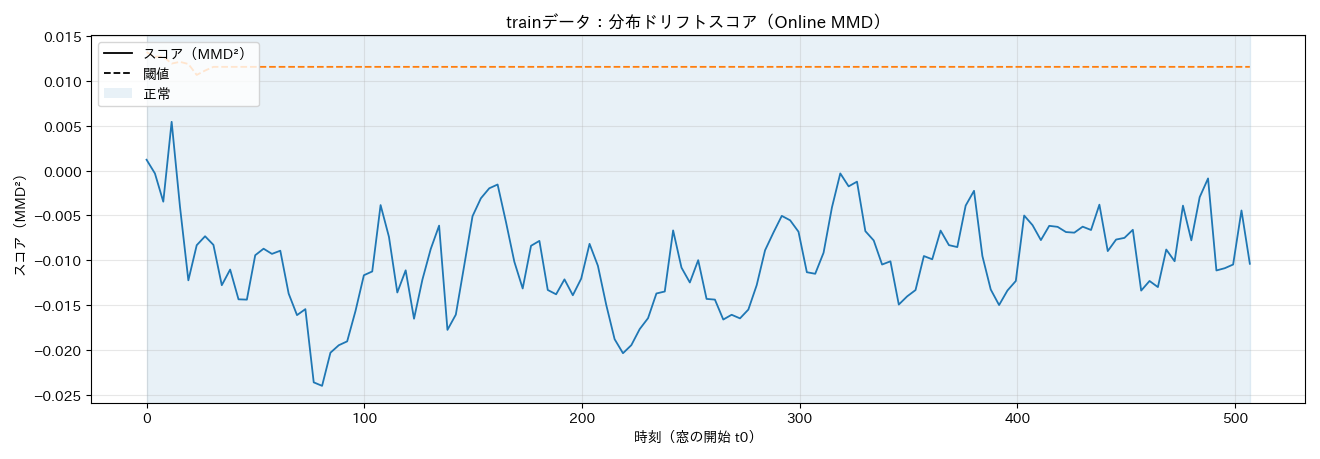

In [27]:
# ============================================================
# 5) train をそのまま流してスコア算出（可視化用ログ作成）
#    ※参照に使った先頭 REF_LEN を含めて流すなら STREAM_START=0
#      参照区間の直後から見たいなら STREAM_START=ref_end
# ============================================================
STREAM_START = 0  # または STREAM_START = ref_end

X_stream = X_ref_all
X_stream_std = scaler.transform(X_stream).astype(np.float32)

meta_stream = meta_train.iloc[STREAM_START:].reset_index(drop=True)
y_stream = None if y_train_win is None else y_train_win[STREAM_START:]

n = X_stream_std.shape[0]
mmd2 = np.full(n, np.nan, dtype=float)
thr  = np.full(n, np.nan, dtype=float)
is_drift = np.zeros(n, dtype=int)

for i in range(n):
    out = cd.predict(X_stream_std[i], return_test_stat=True)
    d = out["data"]
    mmd2[i] = float(d.get("test_stat", np.nan))
    thr[i]  = float(d.get("threshold", np.nan))
    is_drift[i] = int(d.get("is_drift", 0))

df_log = pd.DataFrame({
    "i": np.arange(n),
    "t0": meta_stream["t0"].to_numpy(),
    "win_start": meta_stream["win_start"].to_numpy(),
    "mmd2": mmd2,
    "threshold": thr,
    "is_drift": is_drift,
})

has_label = (y_stream is not None)
if has_label:
    df_log["label"] = y_stream[:n].astype(int)

# ============================================================
# 6) 可視化：スコア波形 + 閾値 + ドリフト点 + （任意）ラベル背景
# ============================================================
t = df_log["t0"].to_numpy()

fig, ax = plt.subplots(figsize=(13.2, 4.6))
ax.set_axisbelow(True)

if has_label:
    y = df_log["label"].to_numpy()
    change = np.flatnonzero(y[1:] != y[:-1]) + 1
    bounds = np.r_[0, change, len(y)]
    for k in range(len(bounds) - 1):
        a, b = int(bounds[k]), int(bounds[k + 1])
        lab = int(y[a])
        ax.axvspan(
            t[a],
            t[b - 1] if b - 1 >= a else t[a],
            alpha=0.10,
            color=label_color.get(lab, "0.8"),
            zorder=0
        )

ax.plot(t, df_log["mmd2"].to_numpy(), linewidth=1.3, label="スコア（MMD²）", zorder=2)
ax.plot(t, df_log["threshold"].to_numpy(), linestyle="--", linewidth=1.3, label="閾値", zorder=2)

m = df_log["is_drift"].to_numpy(dtype=int) == 1
if np.any(m):
    ax.scatter(
        t[m],
        df_log["mmd2"].to_numpy()[m],
        s=18,
        marker="o",
        label="ドリフト検知",
        zorder=3
    )

ax.set_title("trainデータ：分布ドリフトスコア（Online MMD）")
ax.set_xlabel("時刻（窓の開始 t0）")
ax.set_ylabel("スコア（MMD²）")
ax.grid(True, alpha=0.30)

handles = [
    Line2D([0],[0], color="k", linewidth=1.3, label="スコア（MMD²）"),
    Line2D([0],[0], color="k", linestyle="--", linewidth=1.3, label="閾値"),
]
if np.any(m):
    handles.append(Line2D([0],[0], marker="o", color="k", linestyle="None", markersize=6, label="ドリフト検知"))

if has_label:
    labs = np.unique(df_log["label"].to_numpy())
    for lab in labs:
        lab = int(lab)
        handles.append(Patch(
            facecolor=label_color.get(lab, "0.8"),
            alpha=0.10,
            label=label_name.get(lab, str(lab))
        ))

ax.legend(handles=handles, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()

In [28]:
# train を流して可視化した後に test を流すなら必須
cd.reset_state()  # 状態を t=0 に戻す（test_window も空に戻る）

# ============================================================
# 6) スコア算出（テストを1点ずつ流してログ化）
# ============================================================
n = X_test_std.shape[0]
mmd2 = np.full(n, np.nan, dtype=float)
thr  = np.full(n, np.nan, dtype=float)
is_drift = np.zeros(n, dtype=int)

for i in range(n):
    out = cd.predict(X_test_std[i], return_test_stat=True)
    d = out["data"]
    mmd2[i] = float(d.get("test_stat", np.nan))
    thr[i]  = float(d.get("threshold", np.nan))
    is_drift[i] = int(d.get("is_drift", 0))

df_log_test = pd.DataFrame({
    "i": np.arange(n),
    "t0": meta_test["t0"].to_numpy()[:n],          # 窓の開始時刻（time列が無い場合は開始インデックス）
    "win_start": meta_test["win_start"].to_numpy()[:n],
    "mmd2": mmd2,
    "threshold": thr,
    "is_drift": is_drift,
})

# ★重要：背景塗りは「窓ラベル（y_test_win）」を使う（df_testの先頭n点を切るのはNG）
has_label = (y_test_win is not None)
if has_label:
    df_log_test["label"] = y_test_win[:n].astype(int)


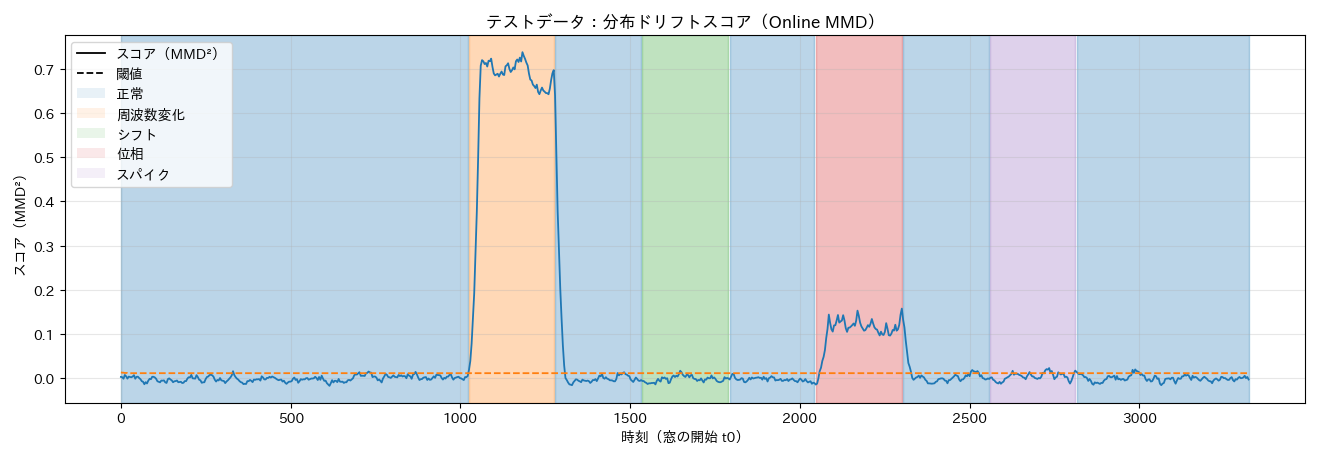

In [29]:
# ============================================================
# 7) 可視化：スコア波形 + 閾値 + ドリフト点 + （任意）ラベル背景
# ============================================================
t = df_log_test["t0"].to_numpy()  # x軸（窓の開始時刻）

fig, ax = plt.subplots(figsize=(13.2, 4.6))
ax.set_axisbelow(True)

# 背景：ラベル区間で塗る（ラベルがある場合のみ）
if has_label:
    y = df_log_test["label"].to_numpy()
    change = np.flatnonzero(y[1:] != y[:-1]) + 1
    bounds = np.r_[0, change, len(y)]
    for k in range(len(bounds) - 1):
        a, b = int(bounds[k]), int(bounds[k + 1])
        lab = int(y[a])
        ax.axvspan(
            t[a],
            t[b - 1] if b - 1 >= a else t[a],
            alpha=0.30,
            color=label_color.get(lab, "0.8"),
            zorder=0
        )

# スコアと閾値
ax.plot(t, df_log_test["mmd2"].to_numpy(), linewidth=1.3, label="スコア（MMD²）", zorder=2)
ax.plot(t, df_log_test["threshold"].to_numpy(), linestyle="--", linewidth=1.3, label="閾値", zorder=2)


ax.set_title("テストデータ：分布ドリフトスコア（Online MMD）")
ax.set_xlabel("時刻（窓の開始 t0）")
ax.set_ylabel("スコア（MMD²）")
ax.grid(True, alpha=0.30)

# 凡例（背景色=区間ラベルも入れる）
handles = [
    Line2D([0],[0], color="k", linewidth=1.3, label="スコア（MMD²）"),
    Line2D([0],[0], color="k", linestyle="--", linewidth=1.3, label="閾値"),
]
if np.any(m):
    handles.append(Line2D([0],[0], marker="o", color="k", linestyle="None", markersize=6, label="ドリフト検知"))

if has_label:
    labs = np.unique(df_log_test["label"].to_numpy())
    for lab in labs:
        lab = int(lab)
        handles.append(Patch(
            facecolor=label_color.get(lab, "0.8"),
            alpha=0.10,
            label=label_name.get(lab, str(lab))
        ))

ax.legend(handles=handles, loc="upper left", frameon=True)

plt.tight_layout()
plt.show()
